In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots
from collections import defaultdict
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)

matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots

from tueplots import bundles, fontsizes, figsizes


from wbml import plot

### Locations

In [168]:
img_folder = 'tmp_imgs'

In [170]:
########### READ LOG FILES ###########

main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
res = "draft_results/"
res_dir = os.path.join(main_dir, res)

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
logs = infinite_defaultdict()

# Column headers
pvi_name = "PVI"
variational_name = "Method"
client_name = "Client"
split_name = "Split"
dataset_name = 'Dataset'
experiment_name ='Experiment name'
num_clients_name = 'Number of clients'

exclude = [
            # Omit Credit - SYNC results
            "draft_results/Credit/Sync/A/07-24-20.54.26_sync-pvi-credit-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",
            
            # Omit Bank - SYNC results
            "draft_results/Bank/Sync/A/07-24-14.47.22_sync-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",  # old PVI
            "draft_results/Bank/Sync/A/07-26-13.29.58_sync-pvi-bank-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l", # non-dampened, longer_l 
            "draft_results/Bank/Sync/A/07-24-16.00.58_sync-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s", # old MFVI

            # Omit Adult - SYNC results
            "draft_results/Adult/Sync/A/07-24-12.41.48_sync-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s", 
            "draft_results/Adult/Sync/A/07-26-13.29.30_sync-pvi-adult-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l",
            "draft_results/Adult/Sync/A/07-24-12.41.02_sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",

            # Non-dampened GI - split B - SYNC results
            "draft_results/Bank/Sync/B/07-26-09.28.21_sync-pvi-bank-10c-10g-2000l-nealprior-splitb-128b-0-02lr-2s-100m-longer-l",
            "draft_results/Adult/Sync/B/07-26-09.27.36_sync-pvi-adult-10c-10g-2000l-nealprior-splitb-128b-0-02lr-2s-100m-longer-l",

            # Non-dampened GI - split A - SEQ results
            "draft_results/Bank/Seq/B/07-25-17.58.15_seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m",
            "draft_results/Adult/Seq/B/07-25-16.02.09_seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m",

            # Non-dampened MFVI - split B - SEQ results
            "draft_results/Adult/Seq/B/07-25-17.56.14_seq-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s",
            "draft_results/Bank/Seq/B/07-25-19.29.52_seq-mfvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s",

        ]

for dataset_type in os.listdir(res_dir):
    if dataset_type in ["Adult", "Bank", "Credit"]:
        for pvi_type in os.listdir(os.path.join(res_dir, dataset_type)):
            for split_type in os.listdir(os.path.join(res_dir, dataset_type, pvi_type)):
                
                exp_dir = os.path.join(res_dir, dataset_type, pvi_type, split_type)

                for exp in os.listdir(exp_dir):

                    q_type = exp.split('_')[1].split('-')[1]
                    num_clients = int(exp.split('_')[1].split('-')[3].split('c')[0])

                    # Erroneous file naming
                    if q_type == 'pvi': q_type = 'gi'
                    
                    metrics_dir = os.path.join(exp_dir, exp, "metrics")
                    _exp_name = '-'.join(exp.split('_')[1:])
                    
                    # Exclude experiments in array
                    if os.path.join(res, dataset_type, pvi_type, split_type, exp) not in exclude:
                    
                        # Existing log file
                        if type(logs[dataset_type][pvi_type][split_type][q_type][experiment_name]) == str:
                            # OVERWRITE EXISTING LOG FILE
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}: {logs[dataset_type][pvi_type][split_type][q_type][experiment_name]} ==> {_exp_name}")
                        else:
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type} = {_exp_name}")

                        logs[dataset_type][pvi_type][split_type][q_type][experiment_name] = _exp_name
                        for log_name in os.listdir(metrics_dir):
                            name = log_name.split('_')[0]
                            
                            logs[dataset_type][pvi_type][split_type][q_type][name] = pd.read_csv(os.path.join(metrics_dir, log_name))

                            # Add column values
                            logs[dataset_type][pvi_type][split_type][q_type][name][pvi_name] = pvi_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][variational_name] = q_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][split_name] = split_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][dataset_name] = dataset_type
                            if name != 'server':
                                logs[dataset_type][pvi_type][split_type][q_type][name][client_name] = name
                            logs[dataset_type][pvi_type][split_type][q_type][name][num_clients_name] = num_clients
                            logs[dataset_type][pvi_type][split_type][q_type][name][experiment_name] = _exp_name

Credit/Seq/A/gi = seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m
Credit/Seq/A/mfvi = seq-mfvi-credit-10c-10g-1000l-nealprior-128b-0-02lr-2s
Credit/GVI/A/gi = seq-pvi-credit-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi
Credit/GVI/A/mfvi = seq-mfvi-credit-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi
Credit/Sync/A/mfvi = sync-mfvi-credit-10c-10g-1000l-nealprior-128b-0-02lr-2s
Credit/Sync/A/gi = sync-pvi-credit-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l
Credit/Sync/B/gi = sync-pvi-credit-10c-10g-2000l-nealprior-splitb-128b-0-02lr-2s-100m-longer-l
Bank/Seq/A/gi = seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m
Bank/Seq/A/mfvi = seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s
Bank/Seq/B/gi = seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1
Bank/Seq/B/mfvi = seq-mfvi-bank-10c-10g-2000l-nealprior-splitb-128b-0-02lr-2s-damp-0-1
Bank/GVI/A/mfvi = seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi
Bank/GVI/A/gi = seq-pvi-bank-

Merge dataframes for plotting purposes.

In [171]:
clients = []
for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name != experiment_name and name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [172]:
servers = []

for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name != experiment_name and name == 'server': servers.append(log)

server = pd.concat(servers, ignore_index=True)

In [173]:
server.groupby(by=[dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Dataset  Split  PVI   Split  Method  Experiment name                                                            
Adult    A      GVI   A      GI      seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi                    11
                             MFVI    sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi                       11
                SEQ   A      GI      seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight        101
                             MFVI    seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi                101
                SYNC  A      GI      sync-pvi-adult-10c-10g-1000l-nealprior-splita-128b-0-02lr-2s-100m-damp-0-1      11
                             MFVI    sync-mfvi-adult-10c-10g-1000l-nealprior-splita-128b-0-02lr-2s-damp-0-1          11
         B      SEQ   B      GI      seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1      101
                             MFVI    seq-mfvi-a

In [174]:
server.groupby(by=[variational_name, dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Method  Dataset  Split  PVI   Split  Method  Experiment name                                                            
GI      Adult    A      GVI   A      GI      seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi                    11
                        SEQ   A      GI      seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight        101
                        SYNC  A      GI      sync-pvi-adult-10c-10g-1000l-nealprior-splita-128b-0-02lr-2s-100m-damp-0-1      11
                 B      SEQ   B      GI      seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1      101
                        SYNC  B      GI      sync-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1      11
        Bank     A      GVI   A      GI      seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m                         11
                        SEQ   A      GI      seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m          

# Plotting

test mll

In [179]:
dataset = "Bank"
split = "B"
omit_sync_mfvi = False
save_plot = False

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'communications'])

append_file_name = "_sync_damp"

# Check whether these are the experiments you want to plot.
data.groupby(by=[variational_name, split_name, dataset_name, experiment_name]).size()

Method  Split  Dataset  Experiment name                                                          
GI      B      Bank     seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1     101
                        sync-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1     11
MFVI    B      Bank     seq-mfvi-bank-10c-10g-2000l-nealprior-splitb-128b-0-02lr-2s-damp-0-1         101
                        sync-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-damp-0-1        11
dtype: int64

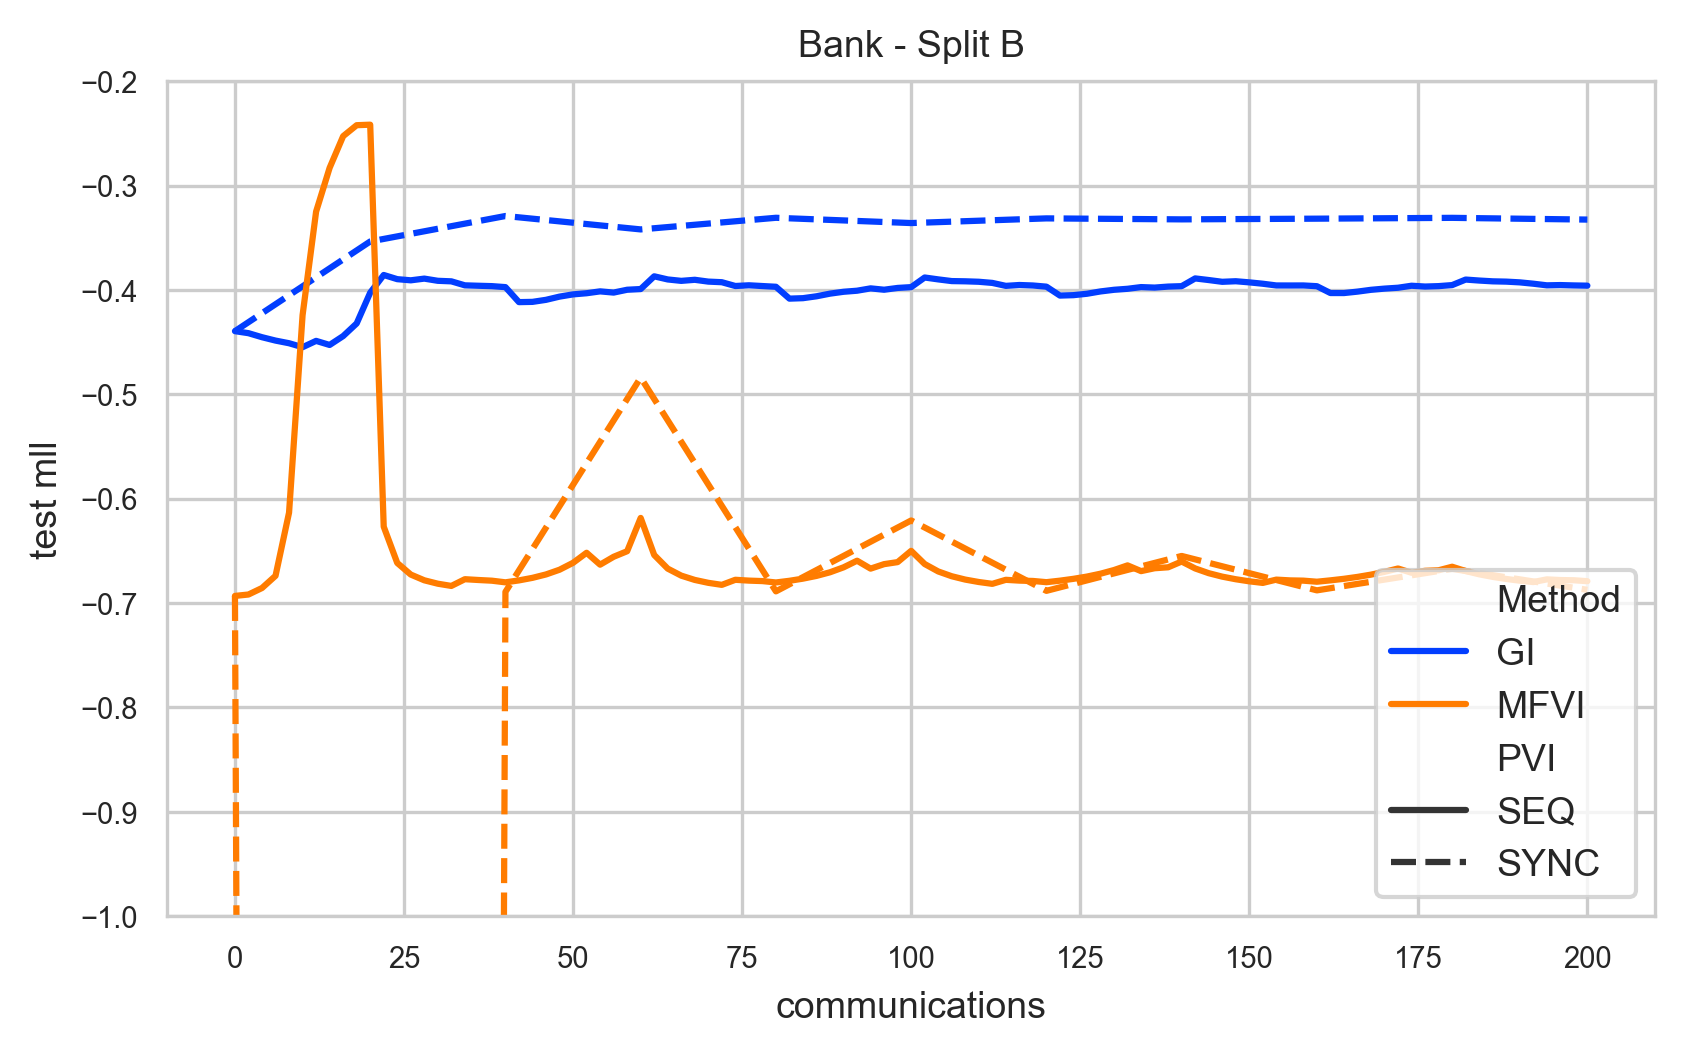

In [180]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_mll'
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_ylim(-1, -0.2)
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    file_name += append_file_name
    if save_plot: plt.savefig(file_name)
    plt.show()

Accuracy

In [135]:
dataset = "Adult"
split = "B"
omit_sync_mfvi = False
save_plot = False

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'communications'])

append_file_name = "_sync_damp"

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1',
       'sync-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m-damp-0-1',
       'seq-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s'],
      dtype=object)

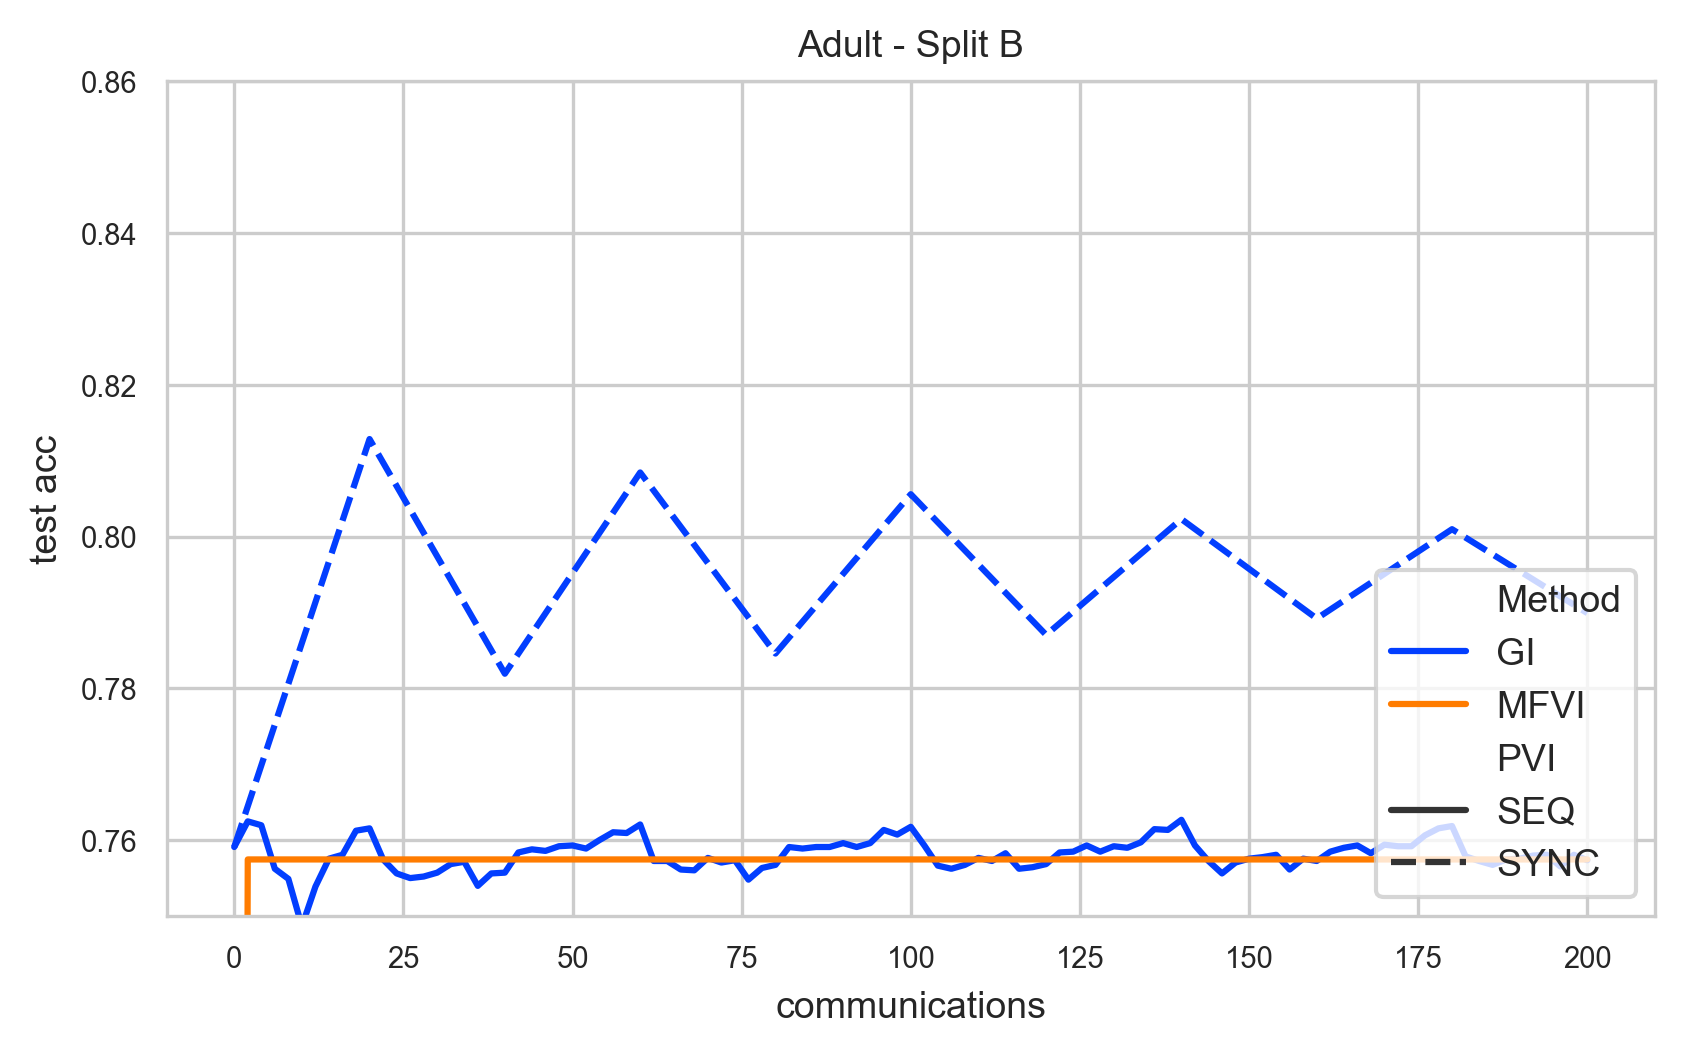

In [136]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    x_metric = 'communications'
    y_metric = 'test_acc'
    
    sns.lineplot(data=data.loc[data[dataset_name] == dataset], x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"


    if dataset.lower() == 'bank':
        ylim=(0.85, 0.91)
        ax.set_ylim(ylim)
    elif dataset.lower() == 'adult':
        ylim=(0.75, 0.86)
        ax.set_ylim(ylim)

    file_name += append_file_name
    if save_plot: plt.savefig(file_name)
    plt.show()

    

### Client

In [144]:
client

,global_iteration,local_iteration,total_iteration,vfe,ll,kl,error,PVI,Method,Split,Dataset,Client,Number of clients,Experiment name
0,4,0,4000,-5480.679688,-0.666740,284960.687500,0.403846,SEQ,GI,A,Credit,client4,10,seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-...
1,4,49,4049,-20.727762,-0.685214,1042.212402,0.423077,SEQ,GI,A,Credit,client4,10,seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-...
2,4,99,4099,-2.199900,-0.683600,78.847618,0.423077,SEQ,GI,A,Credit,client4,10,seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-...
3,4,149,4149,-1.294518,-0.683534,31.771189,0.423077,SEQ,GI,A,Credit,client4,10,seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-...
4,4,199,4199,-1.112394,-0.683513,22.301823,0.423077,SEQ,GI,A,Credit,client4,10,seq-pvi-credit-10c-10g-1000l-nealprior-128b-0-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44745,9,799,9799,-44.877312,-0.213023,17419.070312,0.031250,SYNC,GI,B,Adult,client1,10,sync-pvi-adult-10c-10g-1000l-nealprior-splitb-...
44746,9,849,9849,-44.851025,-0.186760,17419.062500,0.007812,SYNC,GI,B,Adult,client1,10,sync-pvi-adult-10c-10g-1000l-nealprior-splitb-...
44747,9,899,9899,-44.866192,-0.209030,17416.292969,0.031250,SYNC,GI,B,Adult,client1,10,sync-pvi-adult-10c-10g-1000l-nealprior-splitb-...
44748,9,949,9949,-44.862366,-0.210638,17414.171875,0.023438,SYNC,GI,B,Adult,client1,10,sync-pvi-adult-10c-10g-1000l-nealprior-splitb-...


In [315]:
dataset = "Adult"
split = "A"
omit_sync_mfvi = True
save_plot = False

data = client.loc[client[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'total_iteration'])

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight',
       'seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi',
       'sync-pvi-adult-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l',
       'seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi',
       'sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'],
      dtype=object)

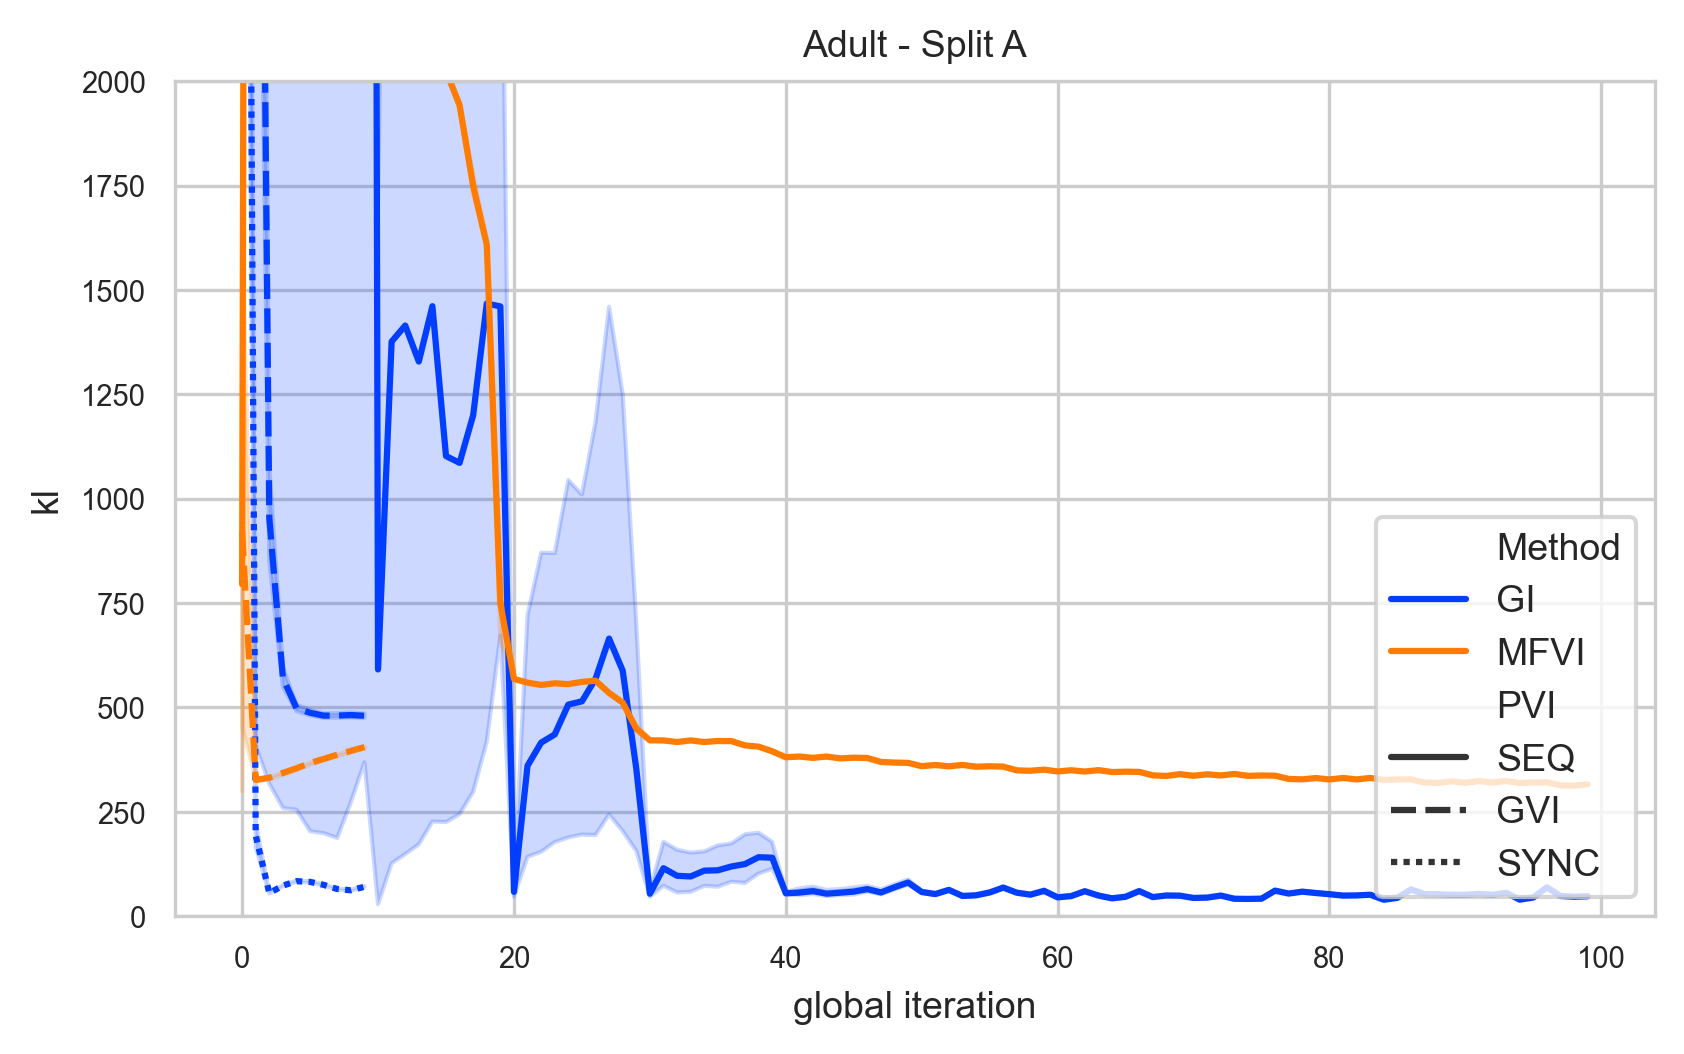

In [321]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    y_metric = "kl"
    x_metric = "global_iteration"
    
    sns.lineplot(data=data.loc[data[dataset_name] == dataset], x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    ax.set_ylim(0, 2000)

    file_name = f"./{img_folder}/{split}_{dataset}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()
